In [1]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd

%matplotlib inline
ox.__version__


'1.2.1'

In [2]:
# testing osmnx download capabilities
# ox.geometries_from_address('Jardim das Américas',{"highway":'footway'}).head()

In [3]:
WORKING_CRS = 'EPSG:31982'

In [4]:
utw = ox.settings.useful_tags_way + ['smoothness','surface']
ox.config(use_cache=True, log_console=True, useful_tags_way=utw)

/home/kaue/.local/lib/python3.8/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


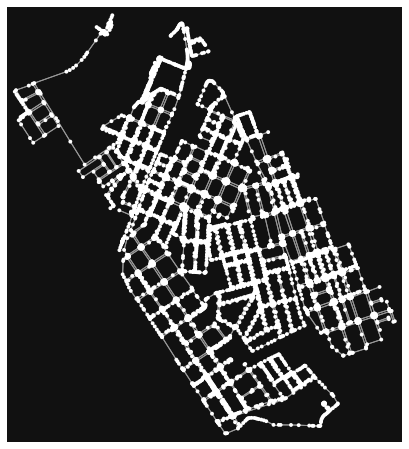

In [5]:
# test getting data using OSMNX:
G0 = ox.graph_from_place("Curitiba", 
# network_type="walk",
custom_filter='["footway"~"sidewalk|crossing"]',
simplify=False,
# retain_all=True,
)
fig, ax = ox.plot_graph(G0)

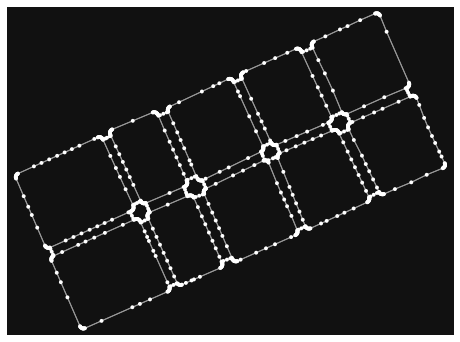

In [16]:
# -25.4646448, -49.2651410 S, W
# -25.4567635, -49.2570238 N, E
# test getting data using OSMNX:
G_tenblocks = ox.graph_from_bbox( -25.4567635,-25.4646448,-49.2570238,-49.2651410,
# network_type="walk",
custom_filter='["footway"~"sidewalk|crossing"]',
simplify=False,
# retain_all=True,
)
fig, ax = ox.plot_graph(G_tenblocks)

In [18]:
tenb_nodes, tenb_edges = ox.utils_graph.graph_to_gdfs(G_tenblocks)

In [20]:
# tenb_nodes.to_file('nodes_test.geojson')
# tenb_edges.to_file('edges_test.geojson')


In [ ]:
# ox.folium.plot_graph_folium(G_tenblocks,popup_attribute='surface')

In [8]:
# to print edges data

# G.edges(data=True)

In [9]:
gdf_nodes,gdf_edges = ox.utils_graph.graph_to_gdfs(G0)


gdf_edges = gdf_edges.reset_index().head()

,u,v,key,osmid,highway,oneway,reversed,length,surface,smoothness,access,name,geometry
0,9815883797,8864131590,0,957990297,footway,False,False,2.990,NaN,NaN,NaN,NaN,"LINESTRING (-49.23170 -25.45899, -49.23172 -25..."
1,9815883797,8864131577,0,957990297,footway,False,True,4.427,NaN,NaN,NaN,NaN,"LINESTRING (-49.23170 -25.45899, -49.23166 -25..."
2,9815883798,8864131593,0,957990299,footway,False,False,1.346,NaN,NaN,NaN,NaN,"LINESTRING (-49.23175 -25.45905, -49.23175 -25..."
3,9815883798,8864131592,0,957990299,footway,False,True,1.335,NaN,NaN,NaN,NaN,"LINESTRING (-49.23175 -25.45905, -49.23174 -25..."
4,8883142697,8883168848,0,960107180,footway,False,False,65.153,NaN,NaN,NaN,NaN,"LINESTRING (-49.22616 -25.47103, -49.22562 -25..."


In [10]:
sidewalks_gdf = gpd.read_file('../data/sidewalks.geojson').set_index(['id']).to_crs(WORKING_CRS)
crossings_gdf = gpd.read_file('../data/crossings.geojson').set_index(['id']).to_crs(WORKING_CRS)
kerbs_gdf = gpd.read_file('../data/kerbs.geojson').set_index(['id']).to_crs(WORKING_CRS)

In [25]:
# checking final scores
kerbs_gdf['final_score'].fillna(0).unique()

array([ 90.,  30., 100.,  50.,  70.,   0.])

In [26]:
crossings_gdf['final_score'].fillna(0).unique()

array([ 51.93277311,  33.10344828,  13.10344828,  31.93277311,
        51.37614679,  48.86075949,  43.10344828,  61.93277311,
        27.53623188,   0.        , 120.        ,  28.86075949,
       130.        , 102.35294118, 114.73684211,  75.        ,
       100.        ,  94.73684211,  82.35294118])

In [27]:
sidewalks_gdf['final_score'].fillna(0).unique()

array([ 13.10344828,  31.93277311,  27.53623188,  28.86075949,
       100.        ,  29.88764045,   0.        ,  68.57142857,
        23.26530612,  31.37614679,  82.35294118,  94.73684211,
        74.66666667,  41.05263158,  46.15384615,  84.70588235,
        58.33333333,  66.66666667,  75.        ,  64.61538462,
        64.28571429,  42.85714286,  50.90909091,  55.38461538,
        43.63636364,  37.5       ,  17.5       ,  60.        ,
        33.33333333,  57.14285714,  27.27272727,  40.        ,
        18.        ])

In [38]:
kerbs_buffered_gdf = kerbs_gdf.buffer(5)

In [37]:
crossings_new_wh_score = []

for index,row in crossings_gdf.iterrows():
    print(row['geometry'])

LINESTRING (673620.3772360258 7185714.959861269, 673613.0452465764 7185730.62015854, 673607.1621108771 7185743.192933731)
LINESTRING (673887.4145347344 7186537.6956587015, 673873.6357180118 7186541.873609911, 673862.2518682391 7186545.322558876)
LINESTRING (668651.2512046727 7179619.897850616, 668640.4466355332 7179627.423326995)
LINESTRING (677404.3550277737 7177755.954014535, 677393.7188106622 7177751.475261608, 677383.6385587724 7177747.22178027)
LINESTRING (671621.3296153571 7181273.992270989, 671613.7760869081 7181270.754474961, 671606.1619507845 7181267.495294832)
LINESTRING (682560.7689157885 7185716.255195687, 682572.7184988055 7185711.671969336)
LINESTRING (677183.6704300522 7181626.587556193, 677178.7810405052 7181628.735079358, 677174.2728641763 7181630.811083112)
LINESTRING (676845.701226349 7179070.72761213, 676830.6453583345 7179064.367996432)
LINESTRING (675284.666696243 7182714.064948123, 675275.587399127 7182706.583767924, 675265.7814837284 7182698.912673225)
LINESTRIN

In [11]:
lines_gdf = pd.concat([sidewalks_gdf,crossings_gdf])

In [13]:
# generating required X and Y fields

kerbs_gdf['x'] = kerbs_gdf.geometry.x
kerbs_gdf['y'] = kerbs_gdf.geometry.y


In [14]:
# G = ox.utils_graph.graph_from_gdfs(kerbs_gdf,lines_gdf)